# Taller 1 Centro Colombia Ingenuo

## Imports

In [10]:
import pandas as pd
import numpy as np
import math
from itertools import combinations
import matplotlib.pyplot as plt

## Carga de datos

In [16]:
def detect_header_row(xlsx_path: str, max_search: int = 30) -> int:
    raw = pd.read_excel(xlsx_path, header=None)
    for i in range(min(max_search, len(raw))):
        row = raw.iloc[i].astype(str).str.upper().tolist()
        if any('LATITUD' == x for x in row) and any('LONGITUD' == x for x in row):
            return i
    return 0

def load_points(xlsx_path: str) -> pd.DataFrame:
    hdr = detect_header_row(xlsx_path)
    df = pd.read_excel(xlsx_path, header=hdr)
    df.columns = [str(c).strip().upper() for c in df.columns]
    name_col_candidates = [c for c in df.columns if 'NOMBRE' in c or 'MUNICIPIO' in c or 'POBLADO' in c]
    lat_col_candidates = [c for c in df.columns if 'LAT' in c]
    lon_col_candidates = [c for c in df.columns if 'LON' in c]
    if not lat_col_candidates or not lon_col_candidates:
        raise ValueError("No se encontraron columnas de LAT/LON.")
    name_col = name_col_candidates[0] if name_col_candidates else None
    lat_col = lat_col_candidates[0]
    lon_col = lon_col_candidates[0]
    keep = [c for c in [name_col, lat_col, lon_col] if c is not None]
    clean = df[keep].dropna()
    rename_map = {}
    if name_col: rename_map[name_col] = 'name'
    rename_map[lat_col] = 'lat'
    rename_map[lon_col] = 'lon'
    clean = clean.rename(columns=rename_map).reset_index(drop=True)
    return clean[['lat','lon'] + (['name'] if 'name' in clean.columns else [])]


## Algoritmo Convex Hull

En esta seccion hay que tener cuidado con las rutas de salida de los resultados:

```python
def run_and_plot(xlsx_path: str, out_png: str = "../results/mec_colombia_visualizacion_innocent.png"):
```

In [17]:
def convex_hull(points: np.ndarray) -> np.ndarray:
    P = np.unique(points, axis=0)
    if len(P) <= 1:
        return P
    P = P[np.lexsort((P[:,1], P[:,0]))]
    def cross(o, a, b):
        return (a[0]-o[0])*(b[1]-o[1]) - (a[1]-o[1])*(b[0]-o[0])
    lower = []
    for p in P:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(tuple(p))
    upper = []
    for p in reversed(P):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(tuple(p))
    hull = np.array(lower[:-1] + upper[:-1])
    return hull

def circumcircle(p, q, r):
    ax, ay = p
    bx, by = q
    cx, cy = r
    d = 2 * (ax*(by - cy) + bx*(cy - ay) + cx*(ay - by))
    if abs(d) < 1e-18: return None
    ux = ((ax*ax + ay*ay)*(by - cy) + (bx*bx + by*by)*(cy - ay) + (cx*cx + cy*cy)*(ay - by)) / d
    uy = ((ax*ax + ay*ay)*(cx - bx) + (bx*bx + by*by)*(ax - cx) + (cx*cx + cy*cy)*(bx - ax)) / d
    center = np.array([ux, uy], dtype=float)
    radius = float(np.hypot(center[0]-ax, center[1]-ay))
    return center, radius

def diameter_circle(p, q):
    center = (p + q) / 2.0
    radius = float(np.hypot(*(p - center)))
    return center, radius

def contains_all(center, radius, points, tol=1e-10):
    d = np.hypot(points[:,0]-center[0], points[:,1]-center[1])
    return np.all(d <= radius + tol)

def mec_by_hull(points: np.ndarray):
    hull = convex_hull(points)
    best = None
    # Triplets
    for i, j, k in combinations(range(len(hull)), 3):
        cc = circumcircle(hull[i], hull[j], hull[k])
        if cc is None: continue
        center, radius = cc
        if best is not None and radius >= best[1]: continue
        if contains_all(center, radius, points):
            best = (center, radius, ('triple', (hull[i], hull[j], hull[k])))
    # Pairs
    if best is None:
        for i, j in combinations(range(len(hull)), 2):
            center, radius = diameter_circle(hull[i], hull[j])
            if best is not None and radius >= best[1]: continue
            if contains_all(center, radius, points):
                best = (center, radius, ('pair', (hull[i], hull[j])))
    return best, hull

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088
    phi1 = math.radians(lat1); phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1); dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R*c

def run_and_plot(xlsx_path: str, out_png: str = "../results/mec_colombia_visualizacion_innocent.png"):
    df = load_points(xlsx_path)
    pts = df[['lat','lon']].to_numpy()
    (best, hull) = mec_by_hull(pts)
    if best is None:
        raise RuntimeError("No se encontró círculo mínimo.")
    center_deg, radius_deg, witness = best
    center_lat, center_lon = float(center_deg[0]), float(center_deg[1])
    # Radio en km
    dists_km = [haversine_km(center_lat, center_lon, float(p[0]), float(p[1])) for p in pts]
    radius_km = max(dists_km)
    # Plot
    fig, ax = plt.subplots(figsize=(8,10))
    ax.scatter(pts[:,1], pts[:,0], s=5, alpha=0.7, label="Poblaciones")
    hull_closed = np.vstack([hull, hull[0]])
    ax.plot(hull_closed[:,1], hull_closed[:,0], linewidth=1.0, label="Envolvente")
    theta = np.linspace(0, 2*np.pi, 720)
    circle_lat = center_lat + radius_deg * np.sin(theta)
    circle_lon = center_lon + radius_deg * np.cos(theta)
    ax.plot(circle_lon, circle_lat, linewidth=1.2, label="Circunferencia (MEC)")
    ax.scatter([center_lon], [center_lat], marker='x', s=60, label="Centro")
    ax.set_xlabel("Longitud (°)"); ax.set_ylabel("Latitud (°)")
    ax.set_title("Círculo mínimo de poblaciones de Colombia")
    ax.legend(loc="best"); ax.set_aspect('equal', adjustable='box')
    fig.tight_layout(); fig.savefig(out_png, dpi=200)
    return (center_lat, center_lon, radius_deg, radius_km, out_png)


## Ejecucion

En este caso pasa lo mismo, si no se tiene el repositorio clonado, se recomienda cambiar las rutas de:

```python
center_lat, center_lon, rdeg, rkm, out = run_and_plot("../data/DIVIPOLA_Municipios.xlsx")
```

{'Centro:': (4.107589737288828, -76.90597982657498), 'Radio (°):': 10.266685953152827, 'Radio (km):': 1141.2207380624677, 'PNG:': '../results/mec_colombia_visualizacion_innocent.png'}


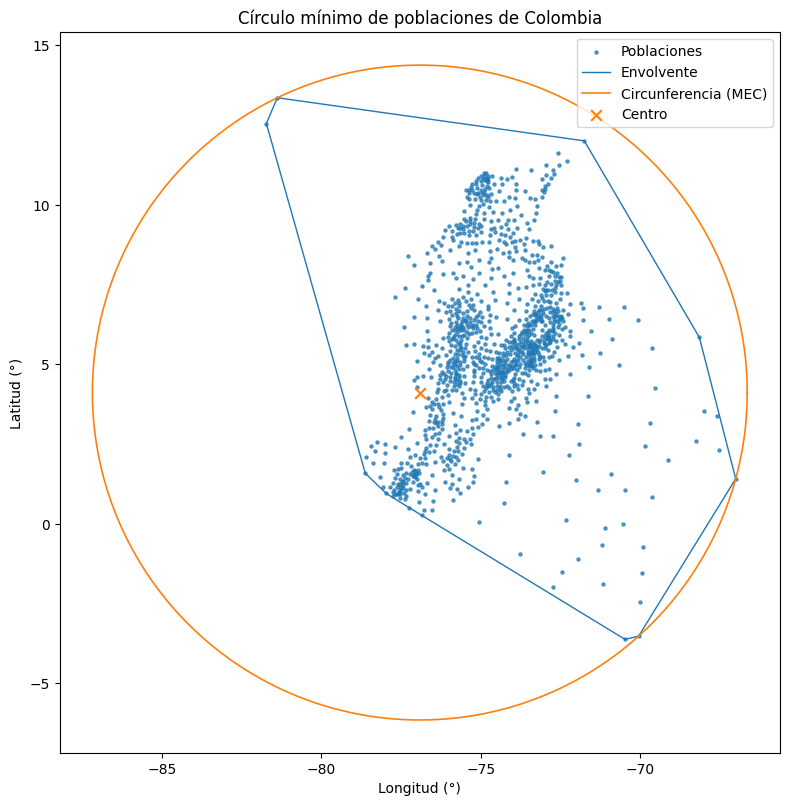

In [19]:
center_lat, center_lon, rdeg, rkm, out = run_and_plot("../data/DIVIPOLA_Municipios.xlsx")
data = {"Centro:": (center_lat, center_lon), "Radio (°):": rdeg, "Radio (km):": rkm, "PNG:": out}
print(data)
pd.DataFrame(data).to_csv('../results/data_innocent.csv')